# Fitting line profiles with lorentzian and Gausian

In [1]:
import sys
sys.path.append('D:/solar flares/data/2017-09-06')
import use_nessi3 as un
import data_analysis as da
import numpy as np
import matplotlib.pyplot as plt
import use_nessi as un
import use_nessi2 as un2
import os
from importlib import reload
# from matplotlib import cm
# import matplotlib.cbook as cbook
# import matplotlib.colors as colors
# from scipy.interpolate import interp1d


In [2]:
lines = ["Ha17", "CaK17", "CaII17"]
long_names = {"Ha17":r"H$\alpha$", "CaK17":r'Ca$IIK$', "CaII17":r'Ca$II 8542 \AA$'}


data0 = un.load_for_further_analysis(lines, full_path="D:/solar flares/data/2017-09-06/")
un2.disgard_cont_point("CaK17", data0)
data0.keys()

dict_keys(['FOV_Ha17', 'quiet_sun_Ha17', 'nessi_Ha17', 'TIME_Ha17', 'FOV_CaK17', 'quiet_sun_CaK17', 'nessi_CaK17', 'TIME_CaK17', 'FOV_CaII17', 'quiet_sun_CaII17', 'nessi_CaII17', 'TIME_CaII17'])

In [3]:
data0['quiet_sun_Ha17']

array([[6.56150000e+03, 6.56200000e+03, 6.56220000e+03, 6.56240000e+03,
        6.56270000e+03, 6.56285000e+03, 6.56300000e+03, 6.56315000e+03,
        6.56330000e+03, 6.56360000e+03, 6.56380000e+03, 6.56400000e+03,
        6.56450000e+03],
       [2.76978401e-08, 2.52960703e-08, 2.27472038e-08, 1.71177930e-08,
        9.99433646e-09, 9.32648929e-09, 9.15971860e-09, 9.58517635e-09,
        1.05578090e-08, 1.84215002e-08, 2.28937997e-08, 2.52214757e-08,
        2.71713987e-08],
       [5.22207581e-02, 3.78950462e-02, 4.08104956e-02, 8.45079795e-02,
        9.83282924e-02, 9.55938324e-02, 9.06255320e-02, 9.14372727e-02,
        8.36121216e-02, 4.07840125e-02, 3.61596309e-02, 3.84186432e-02,
        5.16747981e-02]])

In [4]:
wav, spec, std = data0['quiet_sun_Ha17']
wav, spec


(array([6561.49999988, 6562.        , 6562.19999999, 6562.39999998,
        6562.69999999, 6562.84999999, 6563.        , 6563.15000001,
        6563.30000001, 6563.60000002, 6563.80000001, 6564.        ,
        6564.50000012]),
 array([2.76978401e-08, 2.52960703e-08, 2.27472038e-08, 1.71177930e-08,
        9.99433646e-09, 9.32648929e-09, 9.15971860e-09, 9.58517635e-09,
        1.05578090e-08, 1.84215002e-08, 2.28937997e-08, 2.52214757e-08,
        2.71713987e-08]))

In [5]:
reload(un2)
wav, DFOV , time, line, std = un2.contrast_FOV_data('Ha17', data0, quiet_sun_subtraction=False, num=20)
wav, DFOV , time, line 

(array([6561.49999988, 6561.65789463, 6561.81578938, 6561.97368413,
        6562.13157888, 6562.28947363, 6562.44736838, 6562.60526313,
        6562.76315788, 6562.92105263, 6563.07894737, 6563.23684212,
        6563.39473687, 6563.55263162, 6563.71052637, 6563.86842112,
        6564.02631587, 6564.18421062, 6564.34210537, 6564.50000012]),
 array([[ 0.00721098,  0.02437314,  0.04488658, ...,  0.09023289,
          0.12780213,  0.01229937],
        [ 0.00800826,  0.02504565,  0.04543431, ...,  0.09756207,
          0.1363941 ,  0.02215414],
        [ 0.01733764,  0.03583724,  0.05768812, ...,  0.10685714,
          0.14486771,  0.02980627],
        ...,
        [-0.15422236, -0.14179212, -0.12601061, ..., -0.1066206 ,
         -0.06341475, -0.1732809 ],
        [-0.15383673, -0.14169897, -0.12620993, ..., -0.10550586,
         -0.06184113, -0.1712484 ],
        [-0.15558441, -0.14249761, -0.12605954, ..., -0.1063728 ,
         -0.06198497, -0.17066914]]),
 array([-2.25000000e+00, -2.000

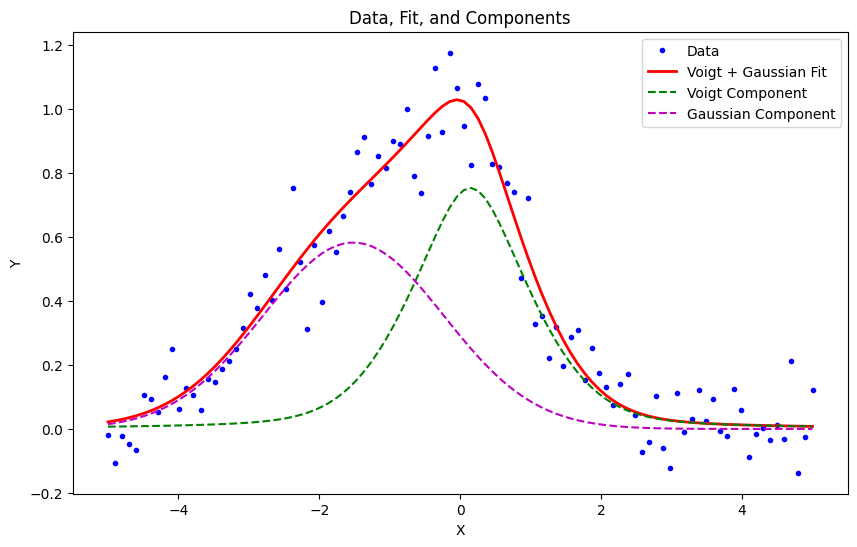

In [6]:
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def gaussian(x, amp_g, cen_g, sigma_g):
    """Gaussian function."""
    return amp_g * np.exp(-(x - cen_g)**2 / (2 * sigma_g**2))

def lorentzian(x, amp_l, cen_l, gamma_l):
    """Lorentzian function."""
    return amp_l * (gamma_l**2 / ((x - cen_l)**2 + gamma_l**2))

def voigt(x, amp_v, cen_v, sigma_v, gamma_v, offset=0):
    """Voigt profile: approximation by combining Gaussian and Lorentzian."""
    f_g = sigma_v**2 / (sigma_v**2 + gamma_v**2)
    return (f_g * gaussian(x, 1, cen_v, sigma_v) +
            (1 - f_g) * lorentzian(x, 1, cen_v, gamma_v)) * amp_v + offset

def voigt_plus_gaussian(x, amp_v, cen_v, sigma_v, gamma_v, amp_g, cen_g, sigma_g):
    """Combination of a Voigt profile and an additional Gaussian."""
    return voigt(x, amp_v, cen_v, sigma_v, gamma_v) + gaussian(x, amp_g, cen_g, sigma_g)

def fit_voigt_and_gaussian(x_data, y_data, initial_guess):
    """Fit a Voigt and Gaussian profile to the data."""
    popt, pcov = curve_fit(voigt_plus_gaussian, x_data, y_data, p0=initial_guess)
    return popt, np.sqrt(np.diag(pcov))

def fit_voigt(x_data, y_data, initial_guess):
    """Fit a Voigt profile to the data."""
    popt, pcov = curve_fit(voigt, x_data, y_data, p0=initial_guess)
    return popt, np.sqrt(np.diag(pcov))

def plot_data_fit_and_components(x_data, y_data, initial_guess, popt=None):
    """Plot the data, fit, and components."""
    if popt is None:
        popt, _ = fit_voigt_and_gaussian(x_data, y_data, initial_guess)
    y_fit = voigt_plus_gaussian(x_data, *popt)
    y_voigt = voigt(x_data, popt[0], popt[1], popt[2], popt[3])
    y_gaussian = gaussian(x_data, popt[4], popt[5], popt[6])
    
    plt.figure(figsize=(10, 6))
    plt.plot(x_data, y_data, 'b.', label='Data')
    plt.plot(x_data, y_fit, 'r-', linewidth=2, label='Voigt + Gaussian Fit')
    plt.plot(x_data, y_voigt, 'g--', label='Voigt Component')
    plt.plot(x_data, y_gaussian, 'm--', label='Gaussian Component')
    plt.title('Data, Fit, and Components')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.show()
    
def plot_data_fit_voigt(x_data, y_data, initial_guess, popt=None, neglect_points=[]):
    """Plot the data, fit, and components."""
    if popt is None:
        popt, _ = fit_voigt(x_data, y_data, initial_guess)
    y_voigt = voigt(x_data, popt[0], popt[1], popt[2], popt[3])        
    y_diff = y_data - y_voigt
    plt.figure(figsize=(10, 6))
    plt.plot(x_data, y_data, 'y.', label='Data neglected')
    plt.plot(np.delete(x_data,neglect_points, axis=0), np.delete(y_data,neglect_points, axis=0), 'b.', label='Data for fit')
    plt.plot(x_data, y_voigt, 'g--', label='Voigt Component')
    plt.plot(x_data, y_diff, 'r--', label='residue')
    plt.title('Data, Fit, and Components')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.show()

# Generate synthetic data
x = np.linspace(-5, 5, 100)
y = voigt_plus_gaussian(x, 1, 0, 1, 0.5, 0.5, -2, 1) + np.random.normal(0, 0.1, len(x))

# Initial guess: [amp_v, cen_v, sigma_v, gamma_v, amp_g, cen_g, sigma_g]
initial_guess = [1, 0, 1, 1, 0.5, 0, 1]

# Plot the data, the fit, and the individual components
plot_data_fit_and_components(x, y, initial_guess)

In [8]:
def contrast_fit_voight_gauss(wav, contrast, intitial_guess, plot_rate=1000):

    param_fit = [] 
    residuals = []
    
    for i in range( np.shape(contrast)[0]):
        param_fit.append(fit_voigt_and_gaussian(wav, contrast[i], initial_guess))
        print(param_fit[i])
        
        if i%plot_rate == plot_rate-1:
            plot_data_fit_and_components(wav, contrast[i], initial_guess)
            
        popt = param_fit[-1][0]
        y_data = contrast[i]
        y_voigt = voigt(wav, popt[0], popt[1], popt[2], popt[3])
        y_diff = y_data - y_voigt
        residuals.append(y_diff)
        
    return param_fit, residuals
        
        
def contrast_fit_voight(wav, contrast, initial_guess, plot_rate=1000, neglect_points=[]):

    param_fit = [] 
    y_fits = []
    residuals = []
    
    for i in range( np.shape(contrast)[0]):
        try:
            w = np.delete(wav, neglect_points, axis=0)
            C = np.delete( contrast[i], neglect_points, axis=0)
            F = fit_voigt(w, C, initial_guess.copy())
            param_fit.append(F)
            
            if i%plot_rate == plot_rate-1:
                print(f'{param_fit[-1] = }. Here comes the plot:')
                plot_data_fit_voigt(wav, contrast[i], initial_guess, popt=F[0], neglect_points=neglect_points)
                
        except RuntimeError:
            if len(param_fit) == 0:
                print(f"At frame {i} the voight fitting was not succesfull and initial guess ({initial_guess}) is used as params and as std of params. ")
                param_fit.append((initial_guess, initial_guess))
            else:
                print(f"At frame {i} the voight fitting was not succesfull and previous params are used. ")
                param_fit.append(param_fit[-1])              
        popt = param_fit[-1][0]
        y_data = contrast[i]
        y_voigt = voigt(wav, popt[0], popt[1], popt[2], popt[3])
        y_fits.append(y_voigt)
        y_diff = y_data - y_voigt
        residuals.append(y_diff)
    try:
        return param_fit, np.array(y_fits) , np.array(residuals)
    except ValueError as error:
        print('The lenght of those arrays does not work out')
        t = [np.shape(k) for k in param_fit]
        print("the shapes of the param_fits:", set(t), t)
        t = [np.shape(k) for k in y_fits]
        print("the shapes of the y_fits:", set(t), t )
        t = [np.shape(k) for k in residuals]
        print("the shapes of the residuals:", set(t) , t)
        raise error
        
def make_analysis(name, data, initial_guess, plot_rate=50, offset=0, neglect_points=[]):
    wav, DFOV , time, line, std = un2.contrast_FOV_data(name, data, quiet_sun_subtraction=False, num=20)
    # print(np.shape(wav), np.shape(DFOV), np.shape(time), np.shape(line))
    # Initial guess: [amp_v, cen_v, sigma_v, gamma_v, amp_g, cen_g, sigma_g]
    # print(np.shape(wav), np.shape(np.delete(wav, neglect_points, axis=0)), wav, np.delete(wav, neglect_points, axis=0))
    # print(np.shape(DFOV+offset), np.shape(np.delete(DFOV+offset, neglect_points, axis=1)), DFOV+offset, np.delete(DFOV+offset, neglect_points, axis=1))
    params, voight, res = contrast_fit_voight(wav, DFOV+offset, initial_guess, plot_rate, neglect_points)
    visualize_analysis(res, voight, wav, time, name)
    save_voight_fits(name, params, res)
    
def save_voight_fits(name, params, res):
    fname = f"fit_data/voight_data_{name}.npz"
    np.savez(fname, params, res)

def load_voigth_data(name):
    fname = f"D:/solar flares/data/voigth_fitting/fit_data/voight_data_{name}.npz"
    data =  np.load(fname) 
    params = data['arr_0']
    res = data["arr_1"]
    return params, res    

def visualize_analysis(res, voight, wav, time, name):
    fig, ax = plt.subplots()

    c = ax.imshow(np.array(res), aspect="auto", cmap='RdBu_r', origin='lower', extent=(wav[0], wav[-1], time[0], time[-1]))
    # pcm = ax.pcolormesh(X, Y, Z, cmap='RdBu_r',vmin=-np.max(Z),  shading='auto')
    cb = fig.colorbar(c, ax=ax, extend='both')
    X, Y = np.meshgrid(wav, time)
    CS = ax.contour(X, Y, voight, colors='black', alpha=0.5)
    ax.clabel(CS, inline=True, fontsize=10) 
    ax.set_xlabel(r"Wavelength [$\AA$]")
    ax.set_ylabel('time from start of flare [min]')
    ax.set_title(f"Voigth fit and Residue analysis for {name} flare")
    cb.set_label(r'the residues after Voigt fit [relative intensity]')
    plt.show()   
    
initial_guesses = {'Ha':[5.55265545e-01, 6.56293638e+03, 5.29257897e-01, 4.96399919e-01], 
                   "CaK":[4.5, 3933.675, -2.66732183e-01, 2.2284e-1], 
                   "CaIR":[1.5,  8.54203173e+03, -2.74932183e-01, -3.61301961e-04]}

def element_from_name(name):
    lines = ['Ha', 'CaK', 'CaI', "Fe6173"]
    for line in lines:
        if line in name:
            return "CaIR" if line=="CaI" else line
    raise ValueError(f'The given name {name} is not known as a spectral name (yet).')


def make_full_analysis(data, names_list, offsets=None, plot_rate=500, init_guesses=initial_guesses, list_neglect_points=None):
    if list_neglect_points is None:
        list_neglect_points = [[] for _ in range(len(names_list))]
    if offsets is None:
        offsets = np.zeros(len(names_list))
    for i, name in enumerate(names_list):
        el = element_from_name(name)
        make_analysis(name, data, init_guesses[el], plot_rate, offset=offsets[i], neglect_points=list_neglect_points[i])
        

param_fit[-1] = (array([5.74631944e-01, 6.56293381e+03, 5.49637426e-01, 5.08465371e-01]), array([0.01917745, 0.01947202, 0.09975837, 0.2066446 ])). Here comes the plot:


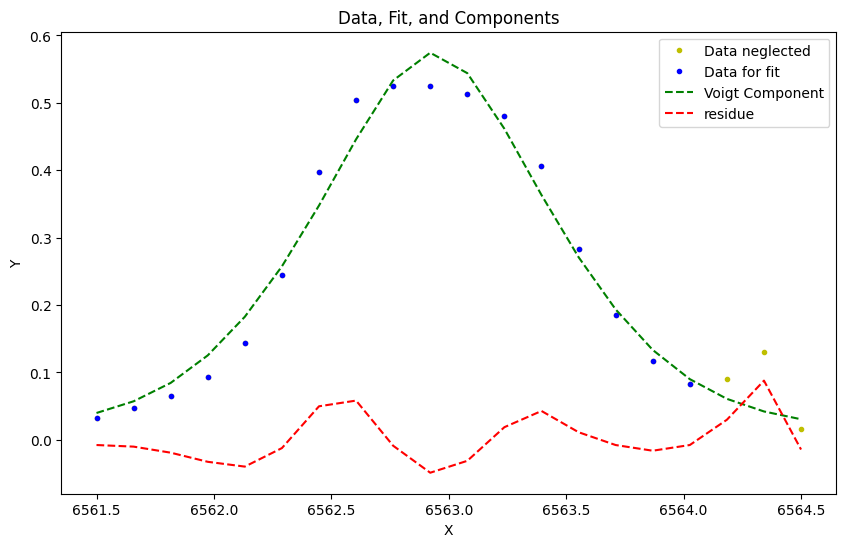

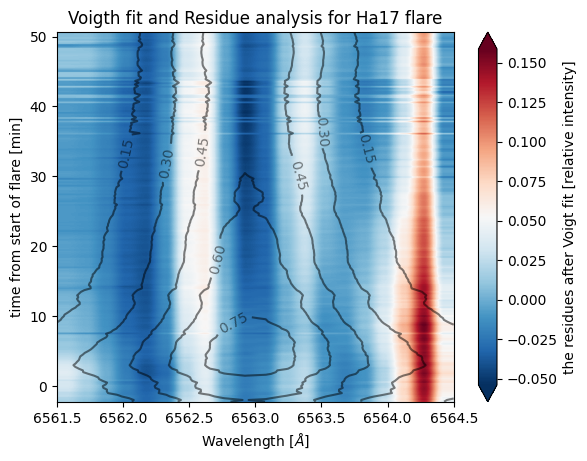

In [13]:
make_analysis('Ha17', data0,[5.55265545e-01, 6.56293638e+03, 5.29257897e-01, 4.96399919e-01], 
              plot_rate=150, offset=0.17, neglect_points=[-3, -2, -1])

param_fit[-1] = (array([ 1.50000000e+00,  8.54203173e+03, -2.74932183e-01, -3.61301961e-04]), array([1.19585361e+01, 1.10773639e-02, 1.16315885e-02, 8.37115608e+02])). Here comes the plot:


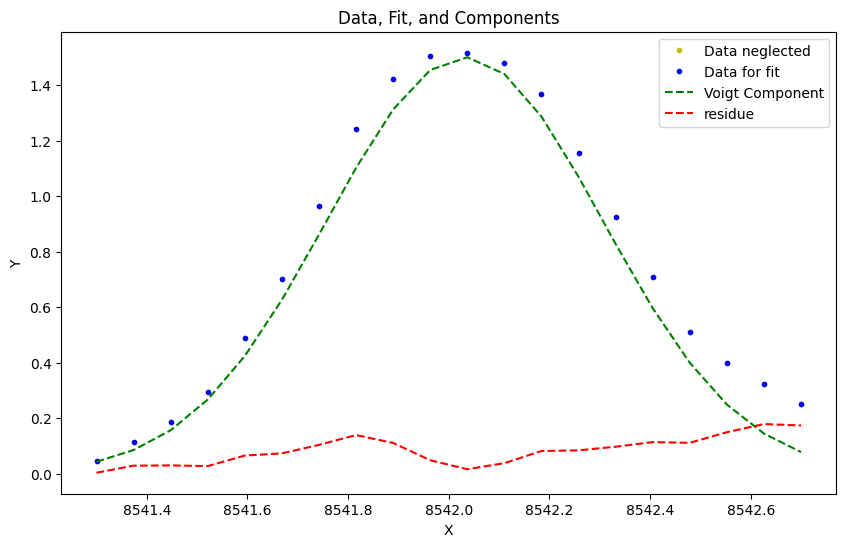

param_fit[-1] = (array([ 1.36200511e+00,  8.54203988e+03, -2.80342240e-01,  1.60867589e-04]), array([3.18764465e+00, 6.25241732e-03, 6.94508882e-03, 5.65103781e+02])). Here comes the plot:


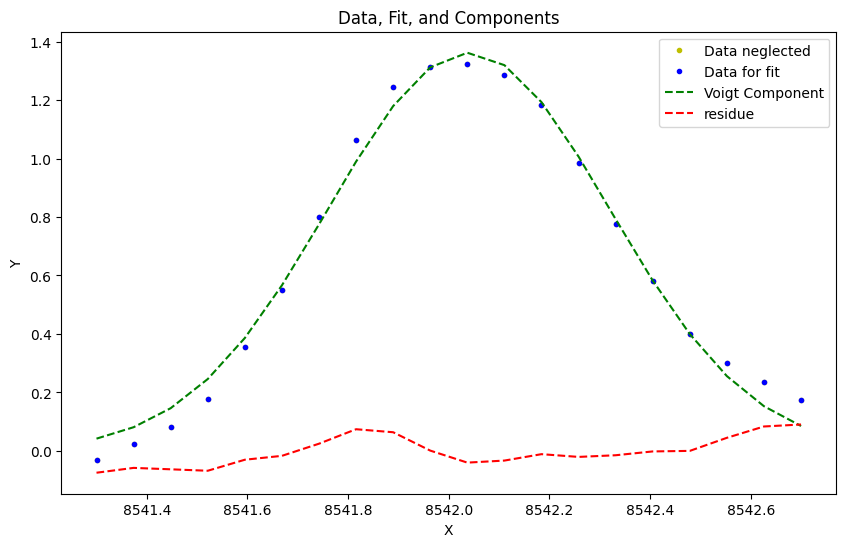

param_fit[-1] = (array([ 1.21801656e+00,  8.54203854e+03, -2.62127141e-01,  2.68526628e-04]), array([1.44799724e+00, 6.50869896e-03, 6.81907476e-03, 1.54008843e+02])). Here comes the plot:


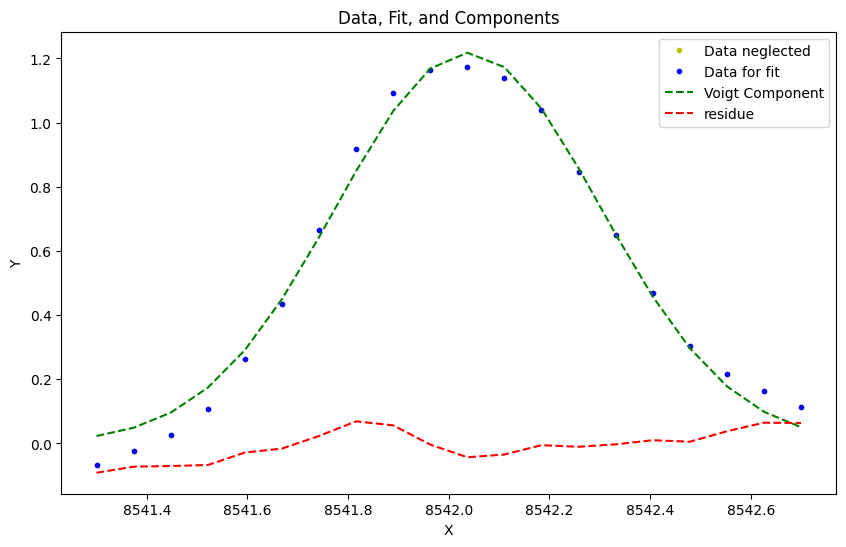

param_fit[-1] = (array([ 1.12348209e+00,  8.54203726e+03, -2.50955035e-01, -2.06215974e-04]), array([1.52020961e-01, 6.55249575e-03, 6.92842393e-03, 2.25148566e+01])). Here comes the plot:


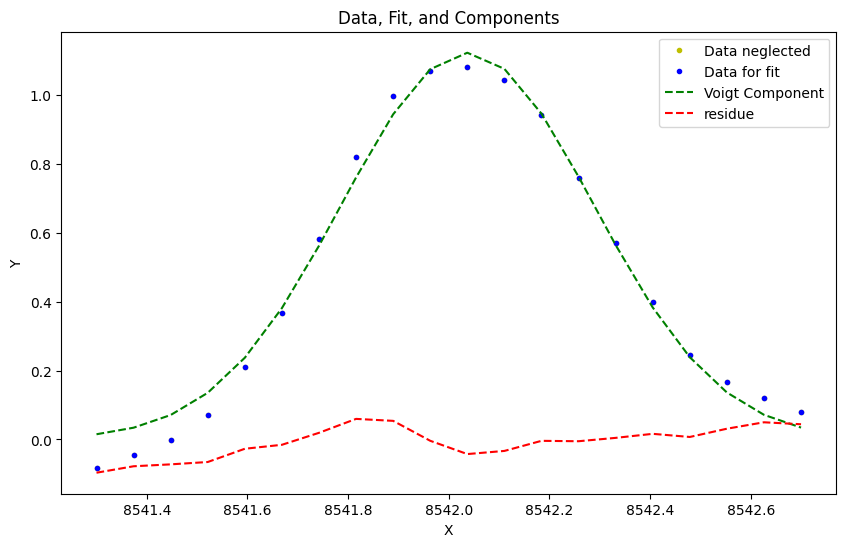

param_fit[-1] = (array([ 1.07643708e+00,  8.54202940e+03, -2.35235931e-01, -5.93577114e-05]), array([4.73005414e-01, 6.91239722e-03, 6.64604632e-03, 2.01973560e+02])). Here comes the plot:


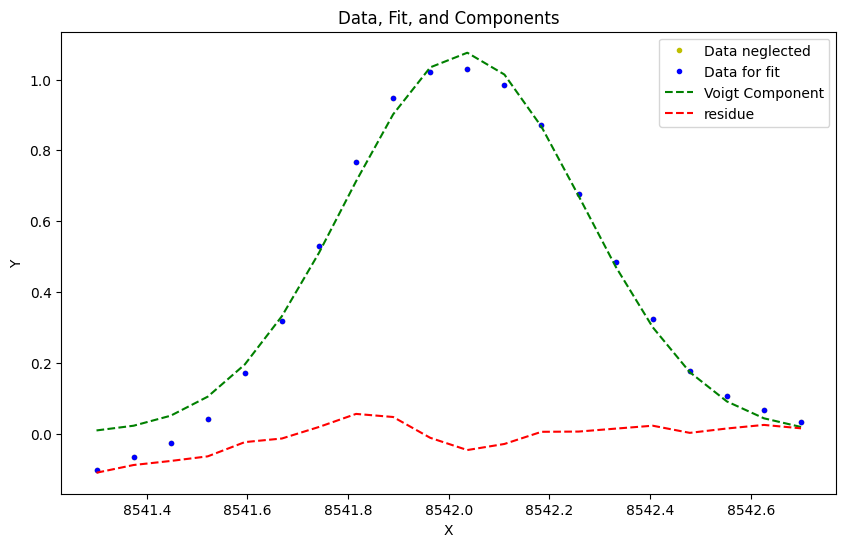

param_fit[-1] = (array([ 1.05884090e+00,  8.54202955e+03, -2.28936132e-01, -2.54148961e-05]), array([1.81899192e-01, 7.07887276e-03, 7.13702262e-03, 1.59362363e+02])). Here comes the plot:


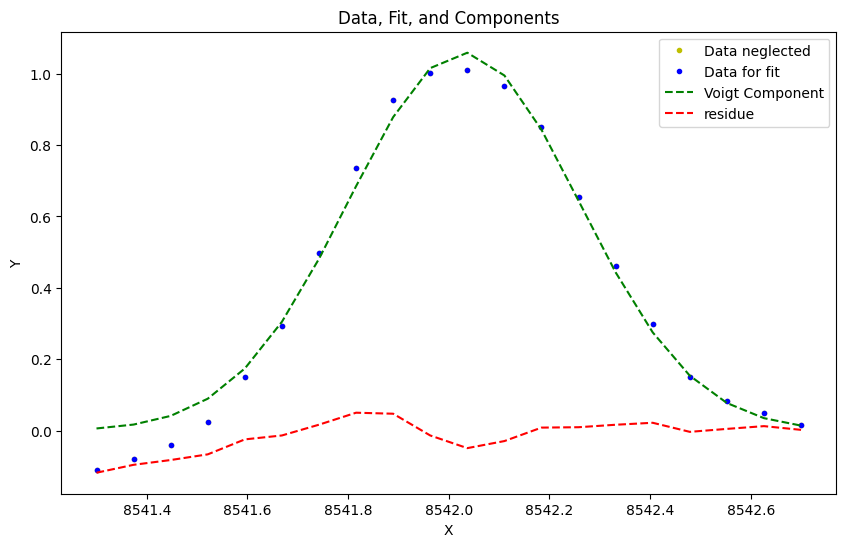

param_fit[-1] = (array([ 1.07926671e+00,  8.54202994e+03, -2.27153350e-01,  2.11836305e-04]), array([9.51562069e+00, 7.96628227e-03, 6.94263921e-03, 1.06988551e+03])). Here comes the plot:


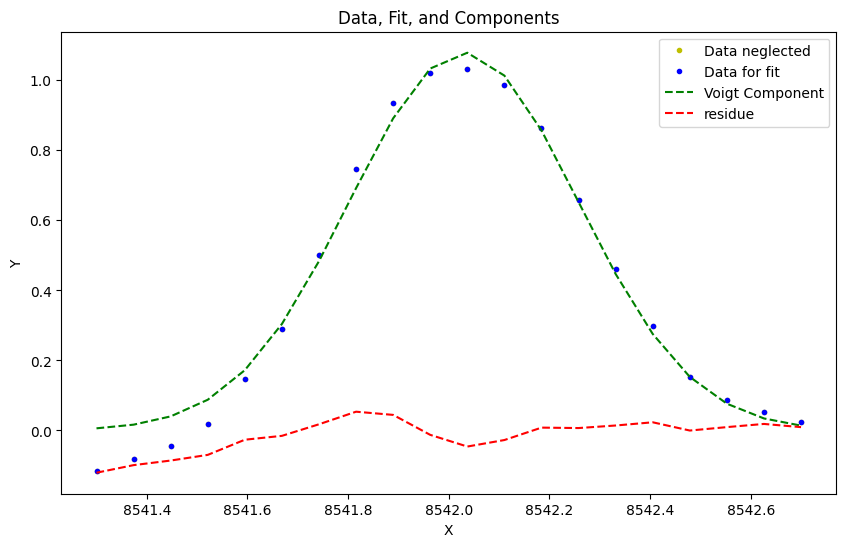

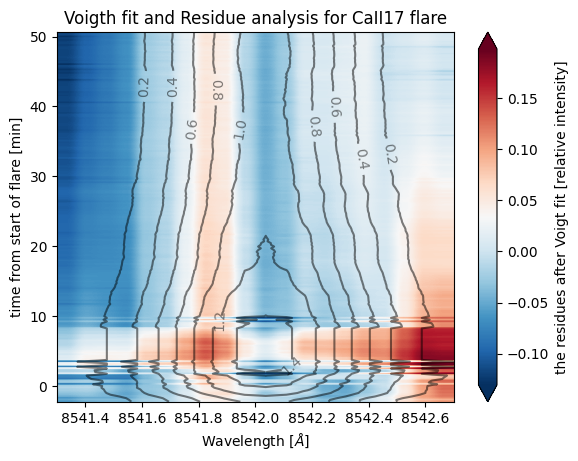

In [14]:
make_analysis('CaII17', data0,[1.5,  8.54203173e+03, -2.74932183e-01, -3.61301961e-04], plot_rate=30)

param_fit[-1] = (array([ 6.23191746e+00,  3.93366396e+03, -2.03620063e-01,  3.02910706e-01]), array([0.09214411, 0.00386757, 0.01465466, 0.00634567])). Here comes the plot:


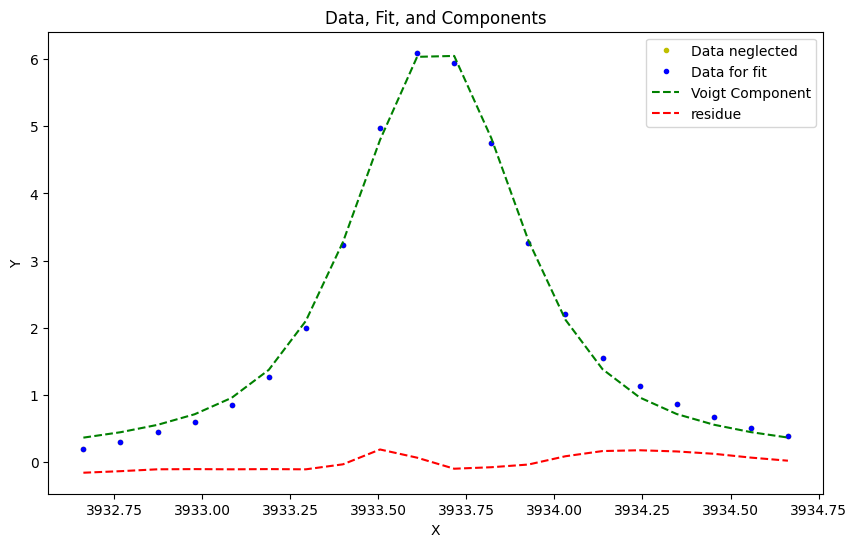

param_fit[-1] = (array([ 4.92324818e+00,  3.93366057e+03, -2.04490114e-01,  2.46998294e-01]), array([0.04650683, 0.00224982, 0.0072624 , 0.00515962])). Here comes the plot:


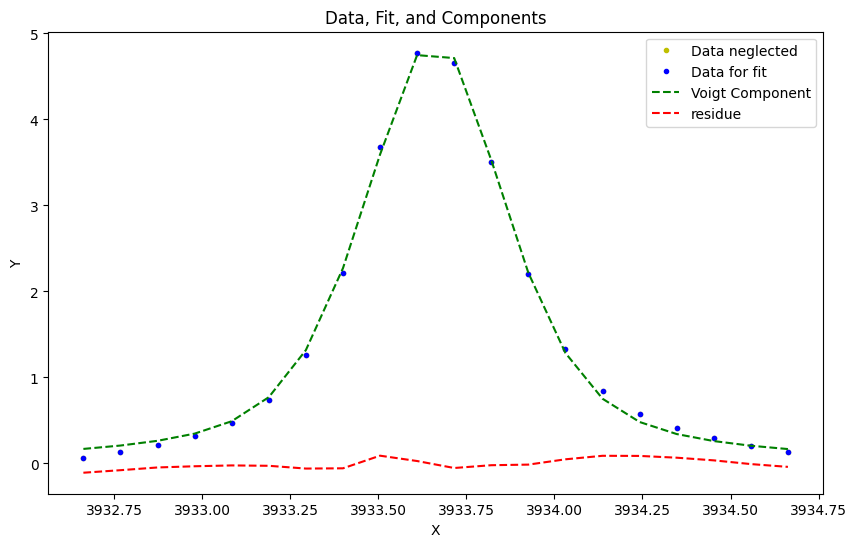

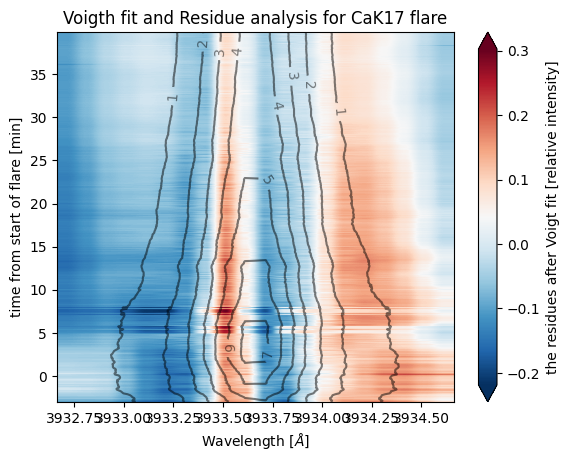

In [15]:
make_analysis('CaK17', data0,[4.5, 3933.675, -2.66732183e-01, 2.2284e-1], plot_rate=150, offset=0.5)

# X2.2 flare at 9 o'clock

In [16]:
lines = ["Ha17_9u"]
long_names = {"Ha17_9u":r"H$\alpha$"}

data = un.load_for_further_analysis(lines, full_path="D:/solar flares/data/2017-09-06/")
data.keys()

dict_keys(['FOV_Ha17_9u', 'quiet_sun_Ha17_9u', 'nessi_Ha17_9u', 'TIME_Ha17_9u'])

param_fit[-1] = (array([ 4.19058071e-01,  6.56298572e+03,  4.56762303e-01, -1.42713663e-04]), array([6.39856032e+00, 1.46485663e-02, 1.51890307e-02, 3.00711839e+03])). Here comes the plot:


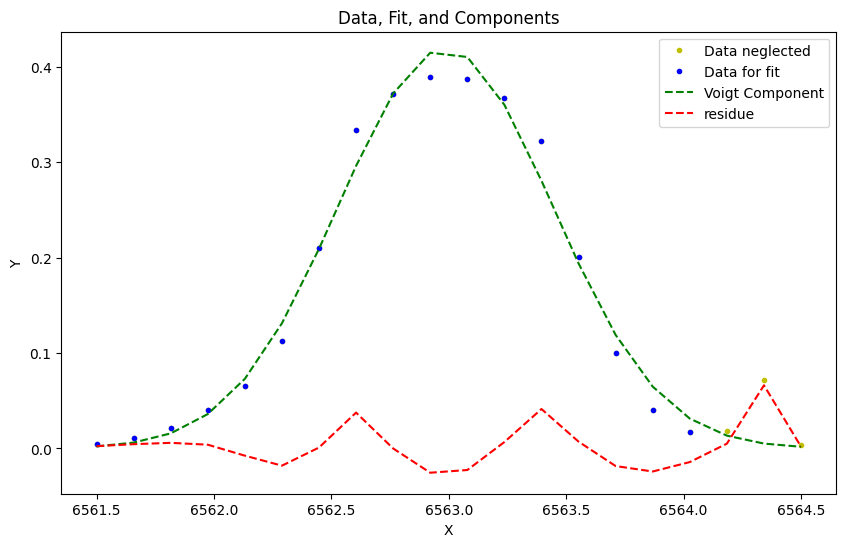

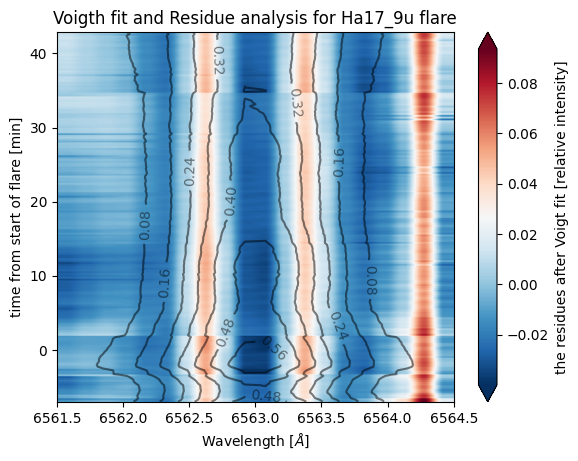

In [17]:
make_full_analysis(data, lines, offsets=[0.2], plot_rate=150, list_neglect_points=[[-3, -2, -1]])


# the C1.3 flare 2013

In [18]:
reload(un)
lines = ["Ha13"]
long_names = {"Ha13":r"H$\alpha$ 2013"}

data = un.load_for_further_analysis(lines, full_path = "D:/solar flares/data/2013-06-30/")
print(data.keys())


dict_keys(['FOV_Ha13', 'quiet_sun_Ha13', 'nessi_Ha13', 'TIME_Ha13'])


param_fit[-1] = (array([2.50362223e-01, 6.56306839e+03, 3.59460333e-01, 3.60160637e-01]), array([0.02573571, 0.03129273, 0.59132666, 1.084075  ])). Here comes the plot:


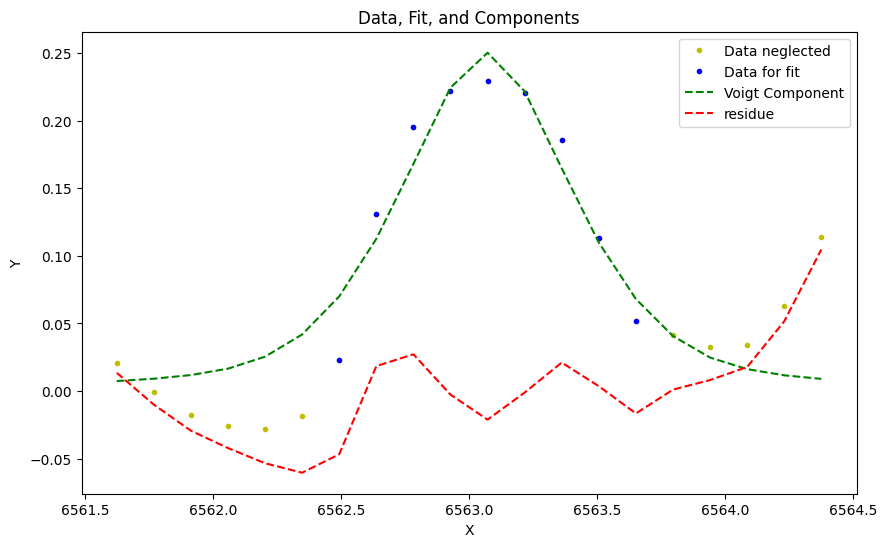

param_fit[-1] = (array([ 2.19399641e-01,  6.56298628e+03,  3.86984345e-01, -3.86716510e-01]), array([0.01890221, 0.02951046, 0.5025753 , 0.93027679])). Here comes the plot:


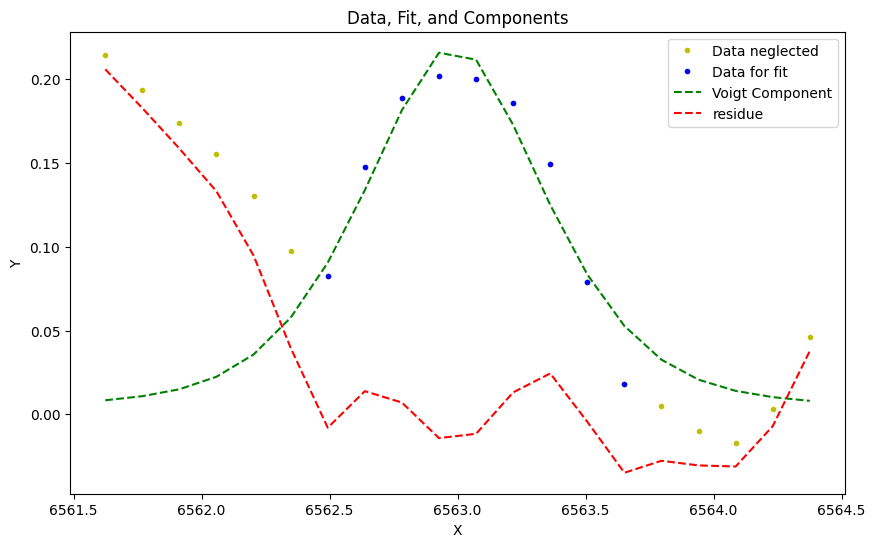

param_fit[-1] = (array([2.05843050e-01, 6.56300838e+03, 3.84537692e-01, 4.15874081e-01]), array([0.01334238, 0.02402908, 0.6075696 , 0.87899021])). Here comes the plot:


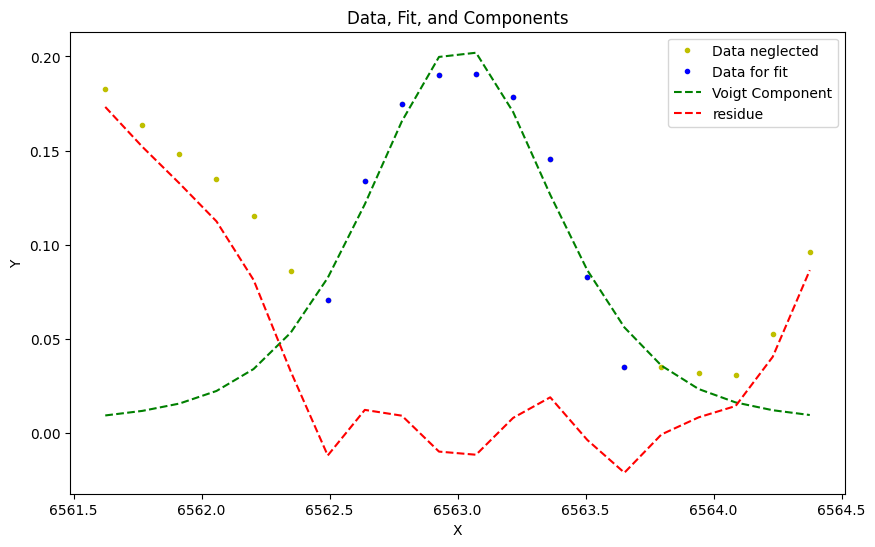

param_fit[-1] = (array([1.81786647e-01, 6.56306163e+03, 3.86576054e-01, 4.50427075e-01]), array([0.01048352, 0.02252991, 1.00035238, 1.17388508])). Here comes the plot:


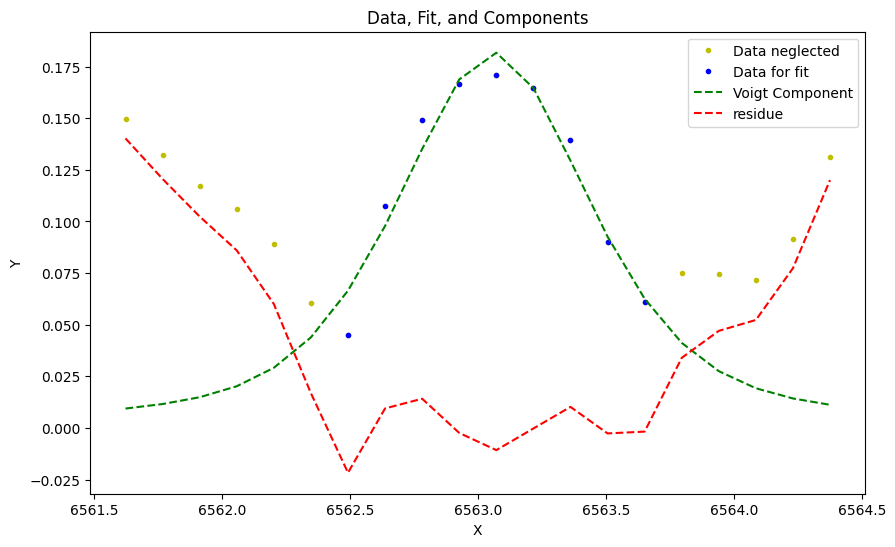

param_fit[-1] = (array([1.67316699e-01, 6.56308142e+03, 3.90262031e-01, 4.45481786e-01]), array([0.0114749 , 0.02492043, 1.06978517, 1.33600755])). Here comes the plot:


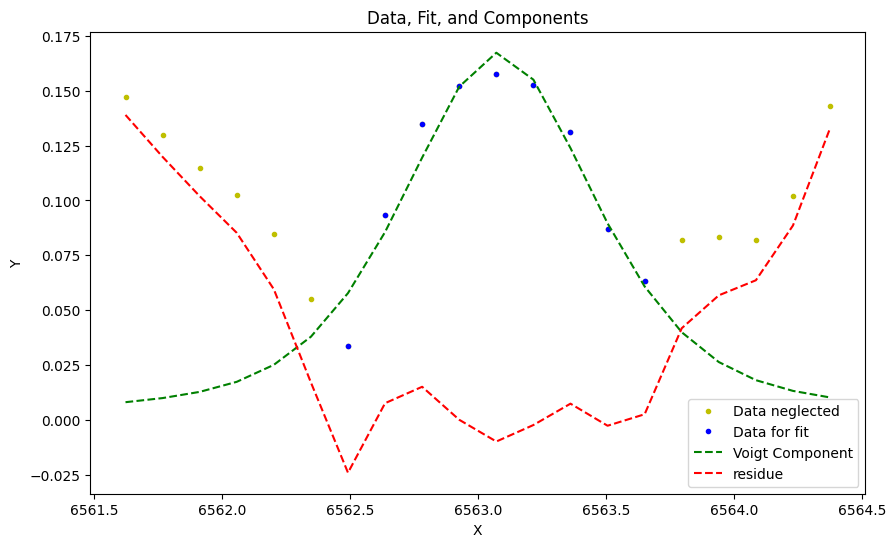

param_fit[-1] = (array([1.60541868e-01, 6.56308659e+03, 3.88399245e-01, 4.38103713e-01]), array([0.01143406, 0.02539774, 1.00547554, 1.2981575 ])). Here comes the plot:


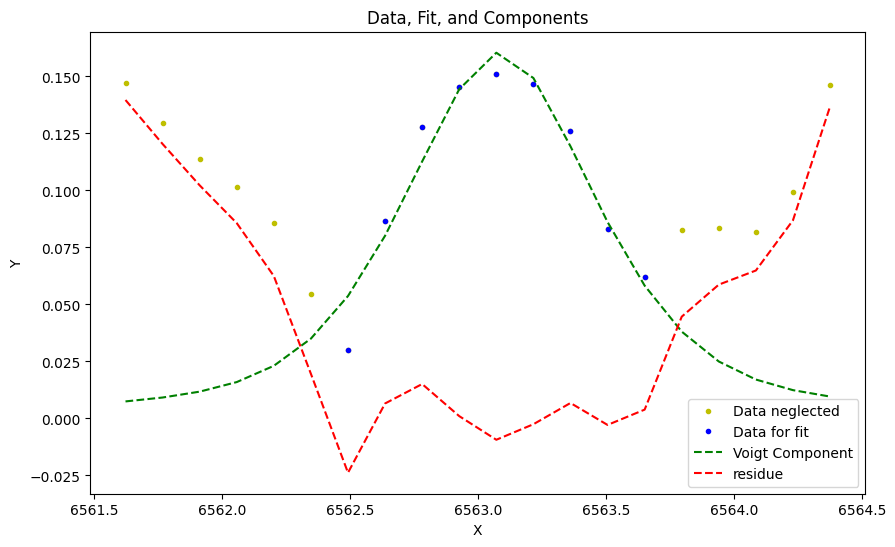

param_fit[-1] = (array([1.56610090e-01, 6.56308968e+03, 3.88843093e-01, 4.35889370e-01]), array([0.01131246, 0.02539556, 0.96562442, 1.27501061])). Here comes the plot:


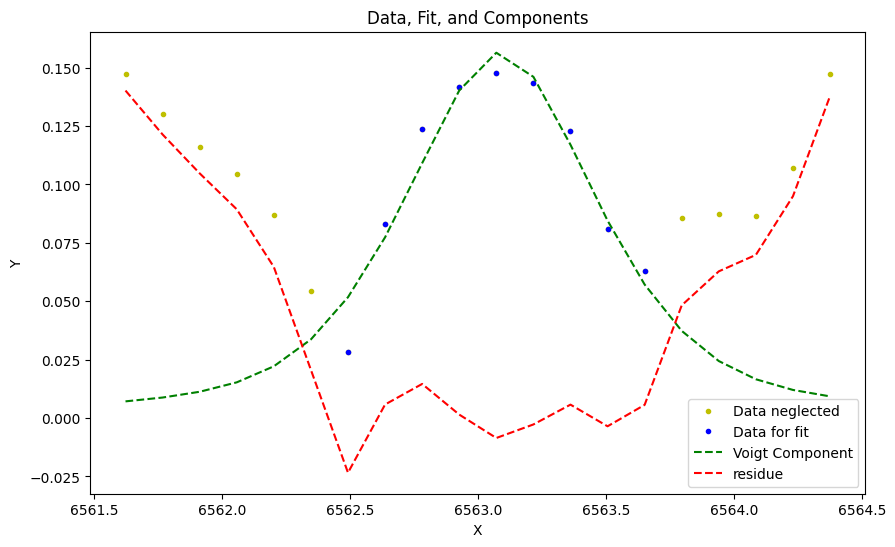

param_fit[-1] = (array([1.55169248e-01, 6.56308461e+03, 3.86970188e-01, 4.36541288e-01]), array([0.01104624, 0.02541331, 1.00127774, 1.29116439])). Here comes the plot:


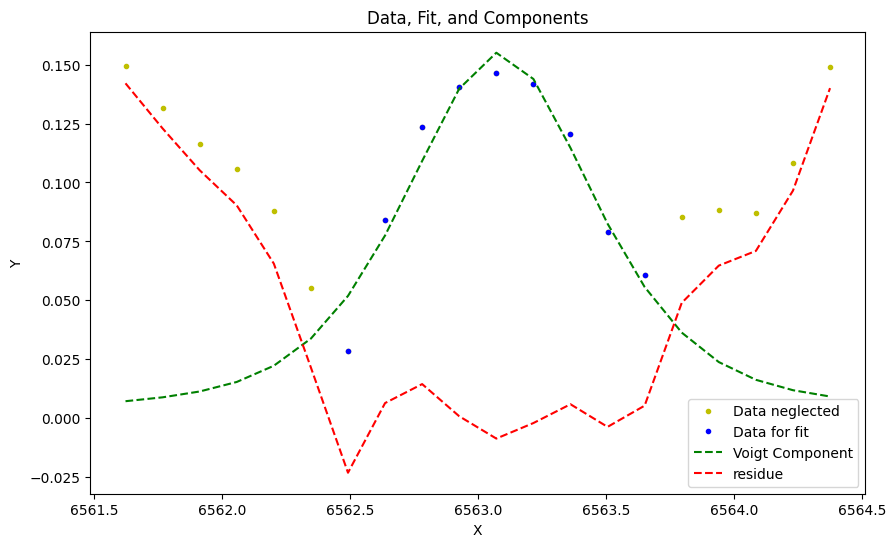

param_fit[-1] = (array([1.57305866e-01, 6.56308173e+03, 3.82067886e-01, 4.29310373e-01]), array([0.01106734, 0.02511372, 0.94097392, 1.22336068])). Here comes the plot:


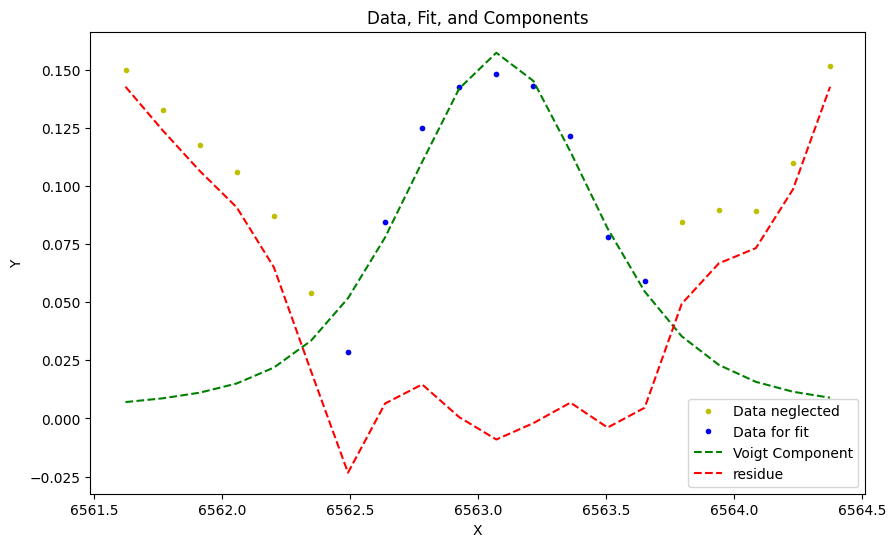

param_fit[-1] = (array([1.55259290e-01, 6.56308394e+03, 3.82249189e-01, 4.26526820e-01]), array([0.01137356, 0.02575774, 0.93351657, 1.23916051])). Here comes the plot:


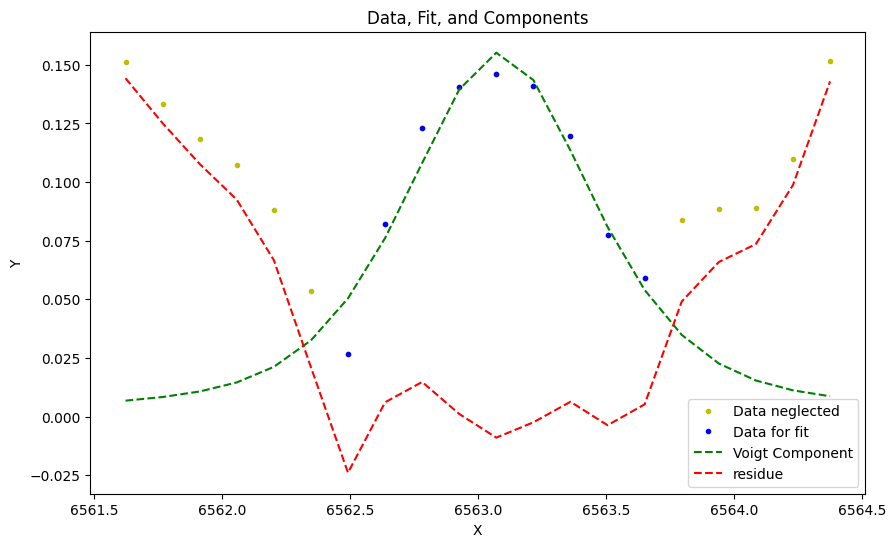

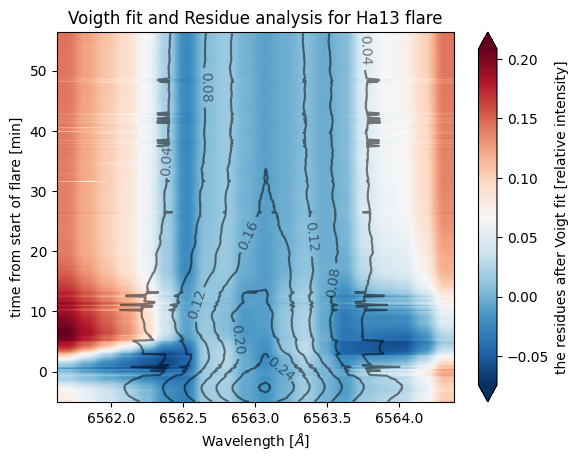

In [20]:
initial_guesses = {'Ha':[5.55265545e-01, 6.56293638e+03, 5.29257897e-01, 4.96399919e-01]}
lnp=[[0,1,2,3,4,5,-5,-4,-3, -2, -1]]
make_full_analysis(data, lines, offsets=[0.09], plot_rate=50, init_guesses=initial_guesses, list_neglect_points=lnp)

# C2.2 flare 2019

dict_keys(['FOV_CaIR19', 'quiet_sun_CaIR19', 'nessi_CaIR19', 'TIME_CaIR19', 'FOV_Fe6173_2019', 'quiet_sun_Fe6173_2019', 'nessi_Fe6173_2019', 'TIME_Fe6173_2019', 'FOV_CaK19', 'quiet_sun_CaK19', 'nessi_CaK19', 'TIME_CaK19'])
param_fit[-1] = (array([ 2.93100088e-01,  8.54195815e+03, -2.62017731e-01,  4.46885934e-04]), array([2.03418401e+00, 1.57604408e-02, 1.65876439e-02, 5.35032957e+02])). Here comes the plot:


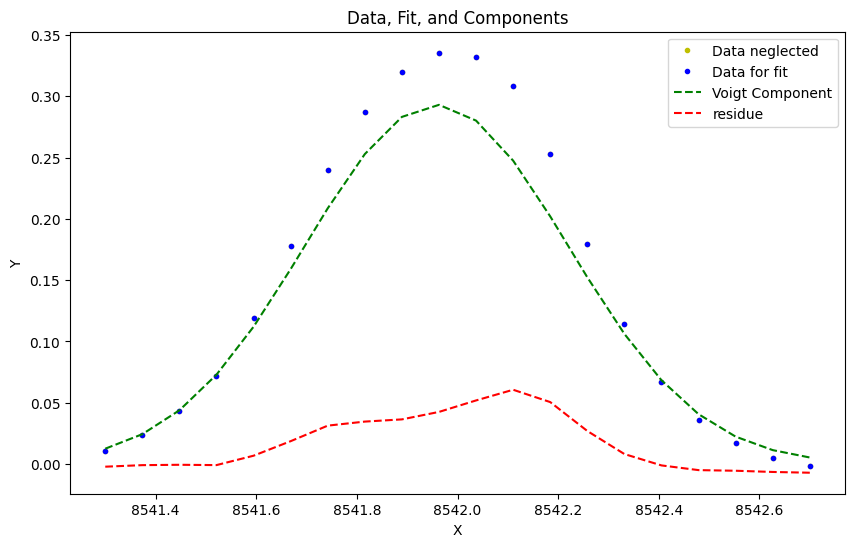

param_fit[-1] = (array([ 2.93100088e-01,  8.54195815e+03, -2.62017731e-01,  4.46885934e-04]), array([5.72916104e-01, 4.43883655e-03, 4.67181349e-03, 1.50688923e+02])). Here comes the plot:


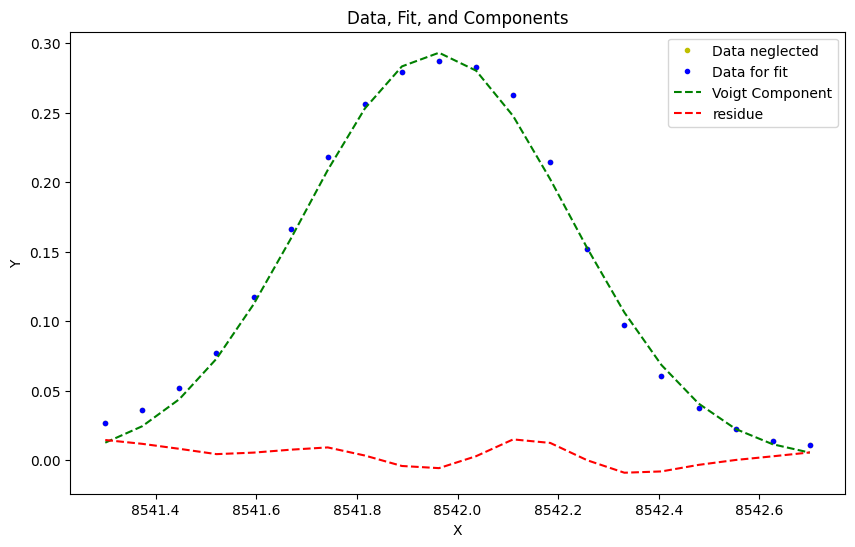

param_fit[-1] = (array([ 2.81016149e-01,  8.54194311e+03, -2.84532914e-01, -6.35823330e-04]), array([5.76679333e+00, 5.96131209e-03, 6.71502098e-03, 1.30744545e+03])). Here comes the plot:


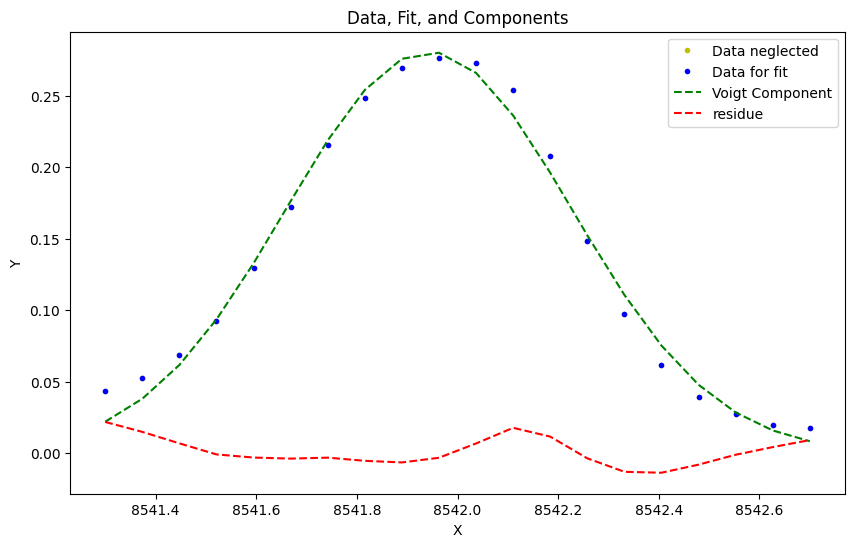

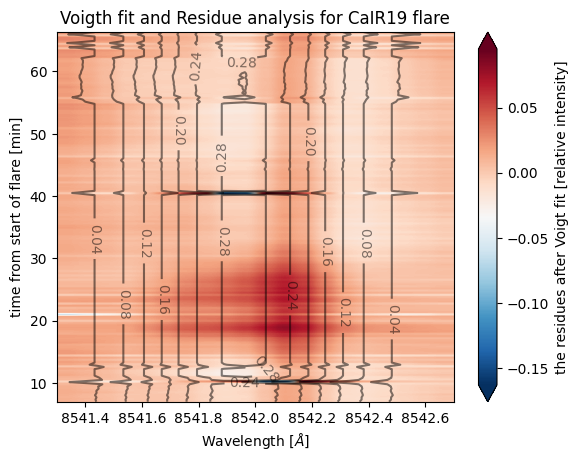

param_fit[-1] = (array([ 1.85229985e-02,  6.17277698e+03, -4.74353535e-03,  1.27365810e-05]), array([inf, inf, inf, inf])). Here comes the plot:


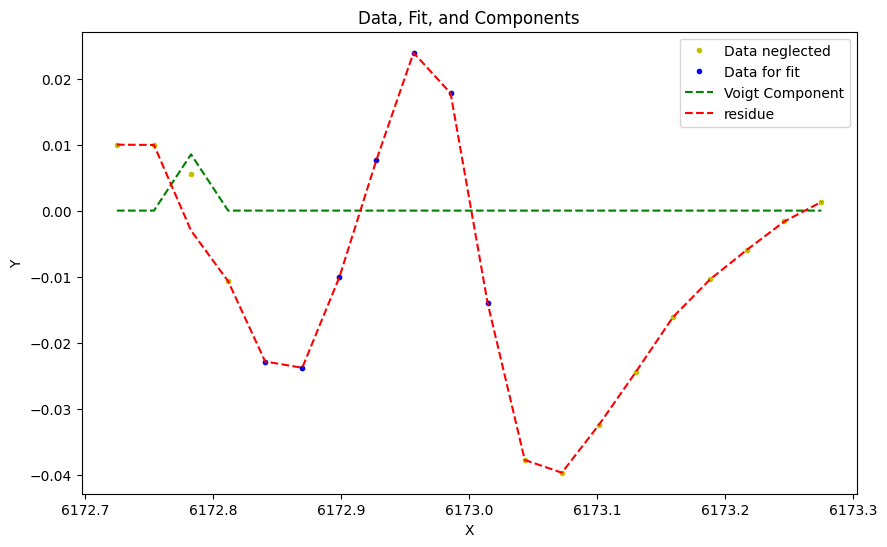

param_fit[-1] = (array([ 4.21461408e-02,  6.17294471e+03, -3.24762720e-02, -5.72977520e-04]), array([7.19408220e+00, 8.67467141e-03, 1.18852397e-02, 1.57800569e+02])). Here comes the plot:


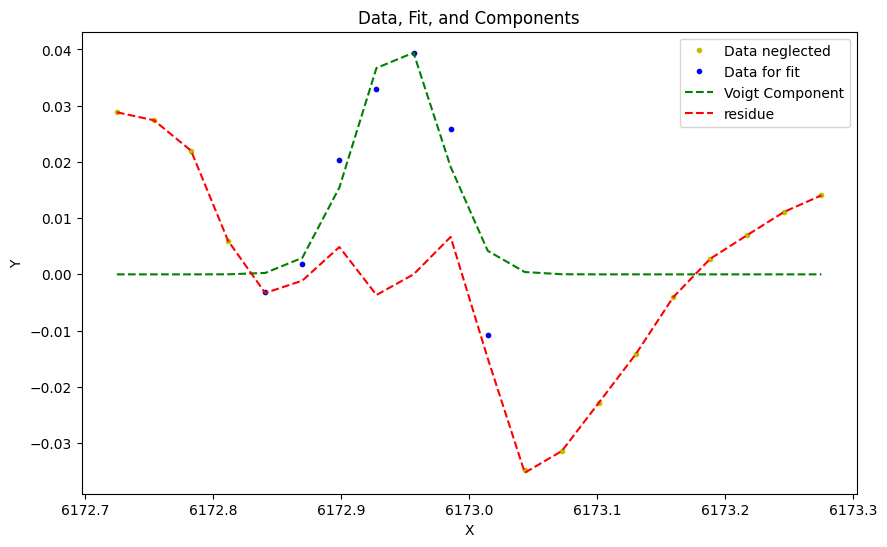

param_fit[-1] = (array([ 4.36457951e-02,  6.17294554e+03, -3.62825032e-02,  8.75839314e-05]), array([1.12254423e+01, 7.13660757e-03, 9.53288010e-03, 4.94638288e+02])). Here comes the plot:


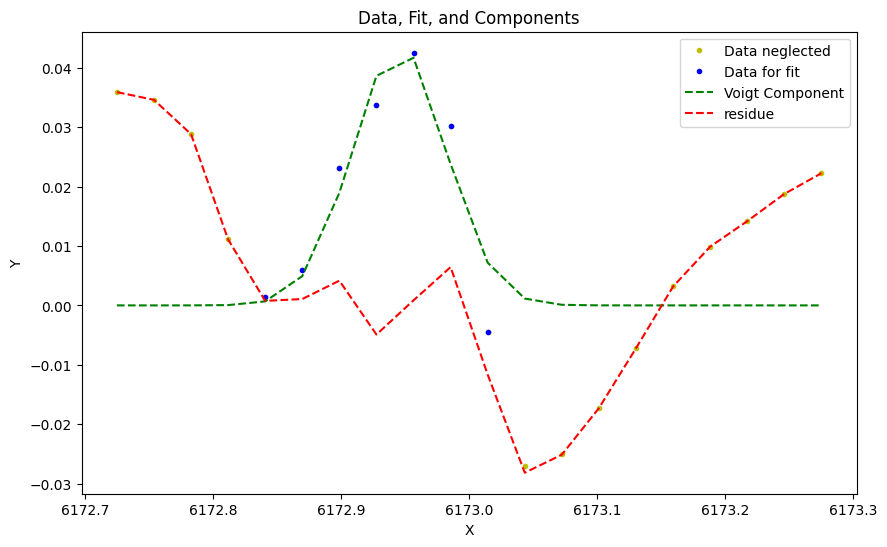

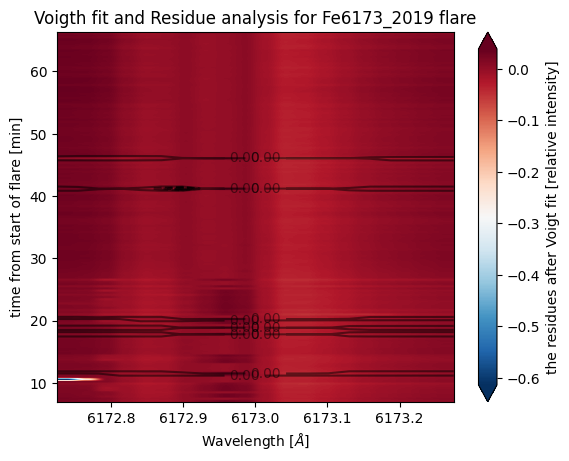

param_fit[-1] = (array([ 1.42332761e+00,  3.93367076e+03, -2.40965955e-01,  3.09300594e-01]), array([0.03846666, 0.00778447, 0.0253315 , 0.01514916])). Here comes the plot:


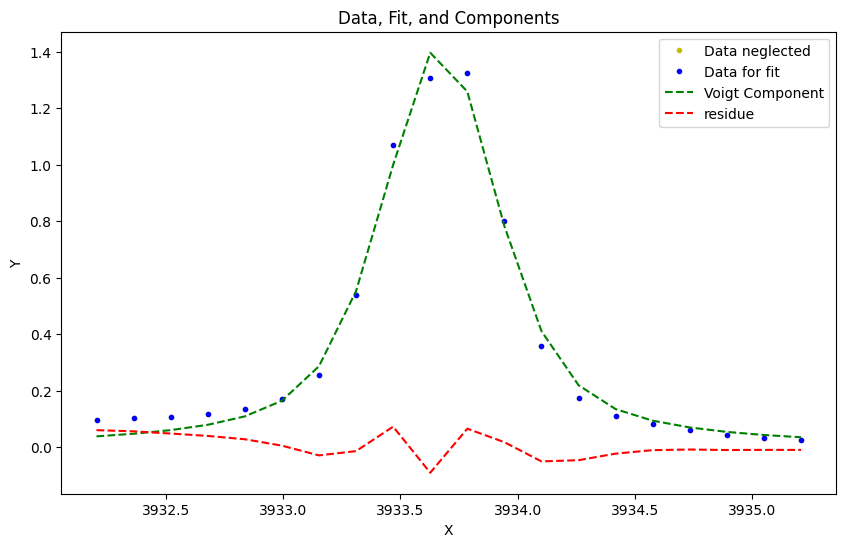

param_fit[-1] = (array([ 1.50500325e+00,  3.93368044e+03, -2.18395087e-01,  3.30600358e-01]), array([0.04713488, 0.00886561, 0.03279874, 0.0139908 ])). Here comes the plot:


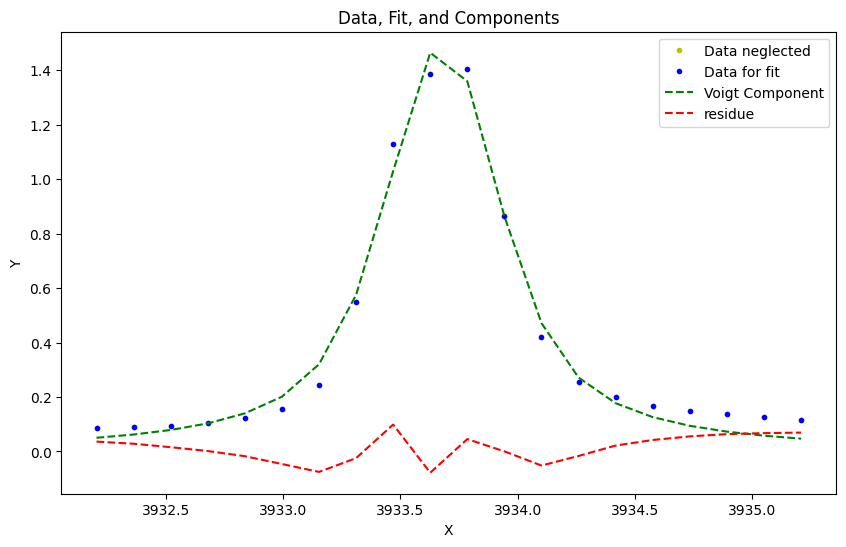

param_fit[-1] = (array([ 1.50597751e+00,  3.93367241e+03, -2.28020615e-01,  3.19931485e-01]), array([0.04628641, 0.00873832, 0.03032136, 0.01474734])). Here comes the plot:


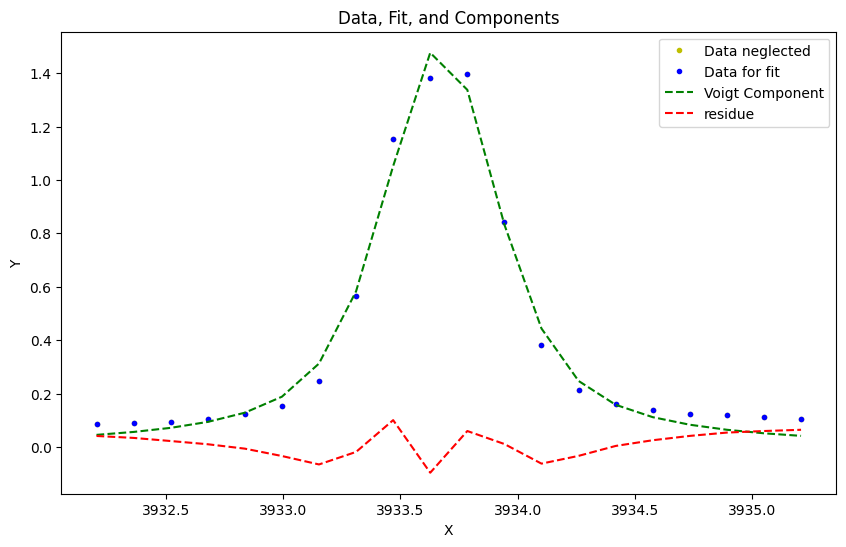

param_fit[-1] = (array([ 1.35346268e+00,  3.93366209e+03, -2.29384190e-01,  3.24080851e-01]), array([0.04867035, 0.0103275 , 0.03605284, 0.01727391])). Here comes the plot:


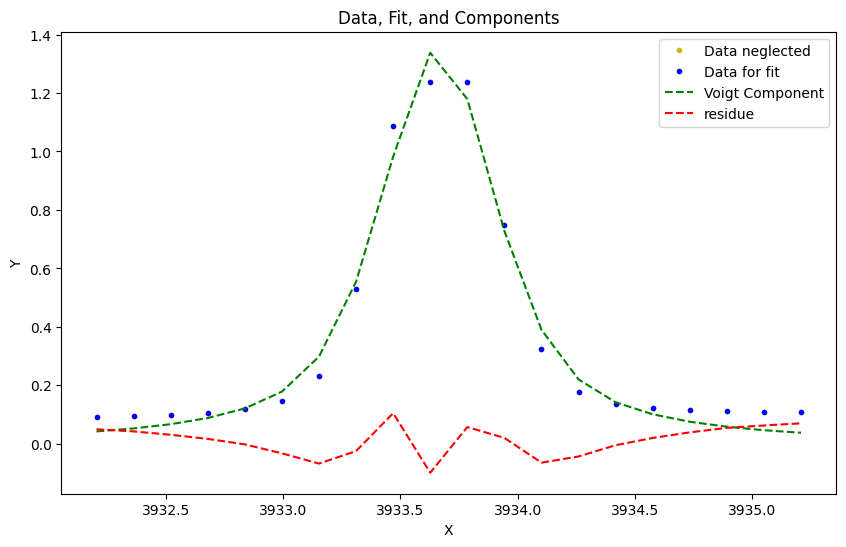

param_fit[-1] = (array([ 1.34105628e+00,  3.93366469e+03, -2.27586595e-01,  3.12555066e-01]), array([0.04672188, 0.0097878 , 0.03337051, 0.01696747])). Here comes the plot:


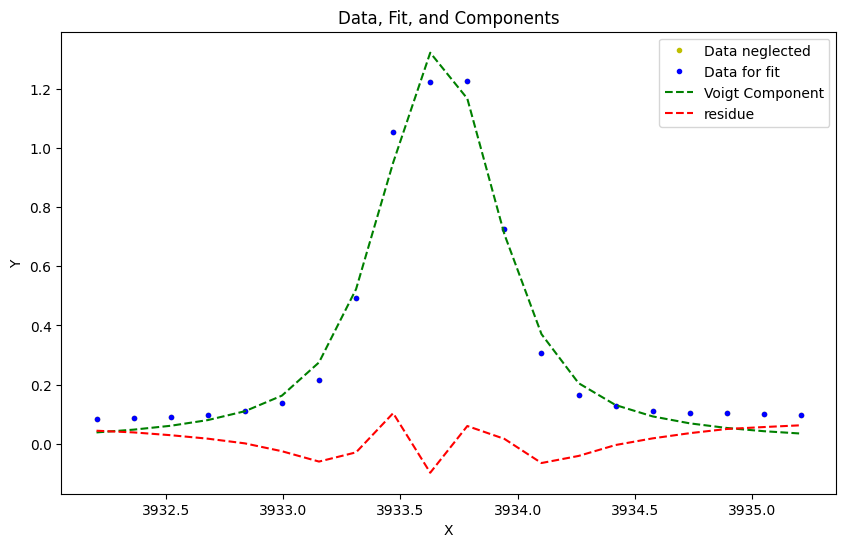

param_fit[-1] = (array([ 1.28436979e+00,  3.93366526e+03, -2.31881689e-01,  3.10829950e-01]), array([0.04463162, 0.00983103, 0.03293975, 0.0176922 ])). Here comes the plot:


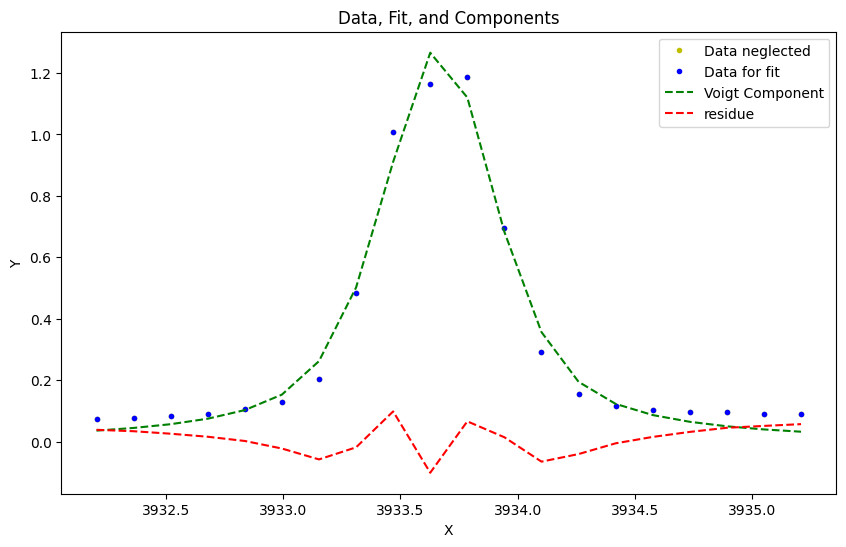

param_fit[-1] = (array([ 1.26989815e+00,  3.93366135e+03, -2.32469862e-01,  3.11915417e-01]), array([0.04529004, 0.01012385, 0.0339455 , 0.0181938 ])). Here comes the plot:


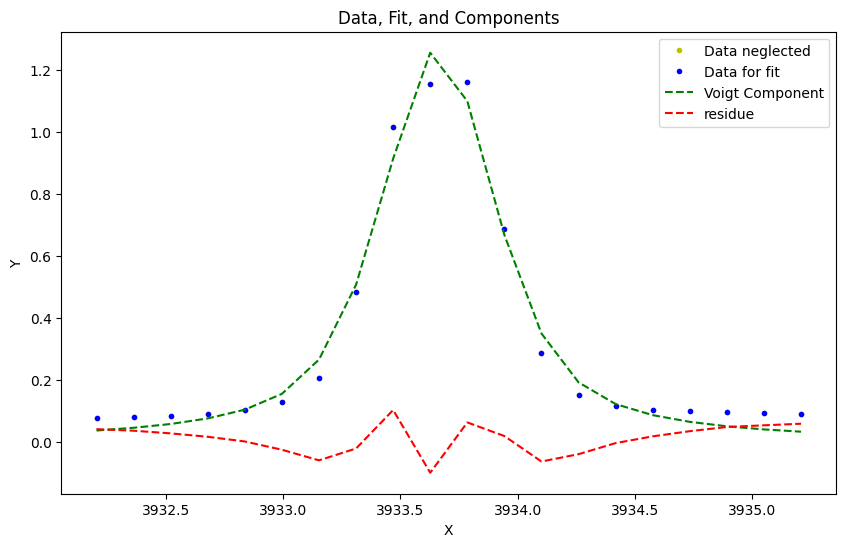

param_fit[-1] = (array([ 1.26890395e+00,  3.93365539e+03, -2.32049822e-01,  3.25904147e-01]), array([0.0442694 , 0.01011017, 0.03514798, 0.01703927])). Here comes the plot:


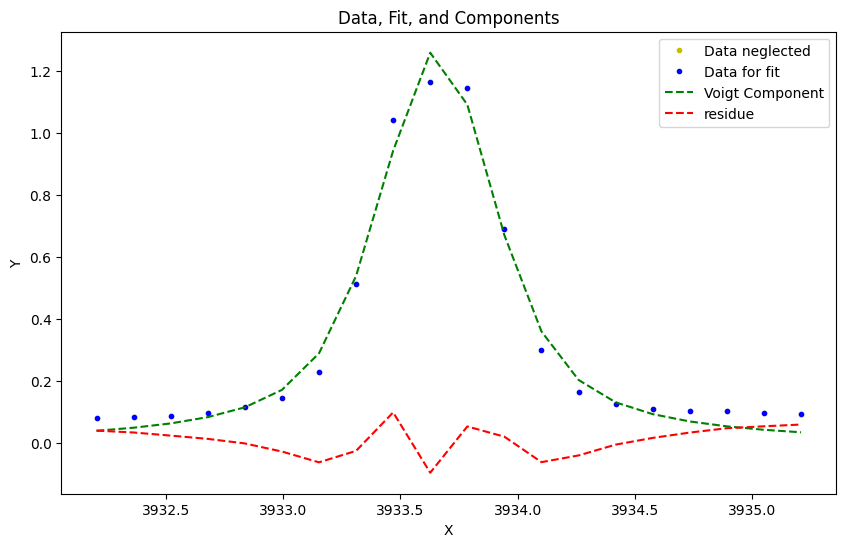

param_fit[-1] = (array([ 1.33613778e+00,  3.93366514e+03, -2.36118561e-01,  3.23462690e-01]), array([0.04036624, 0.00879265, 0.03001841, 0.01533982])). Here comes the plot:


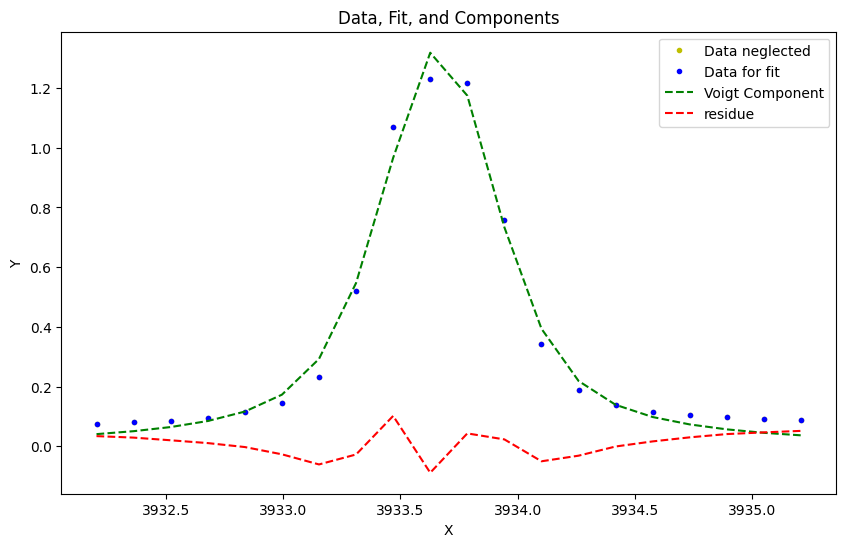

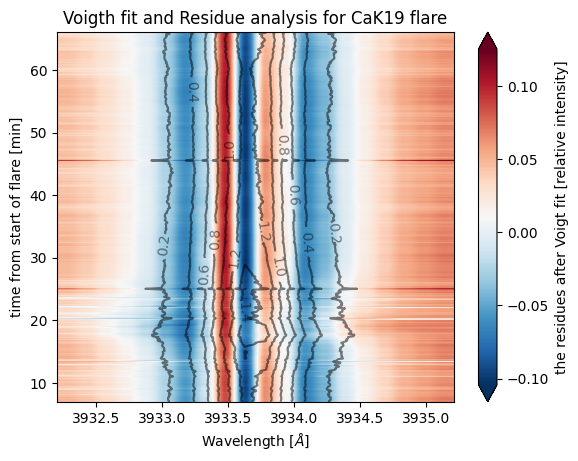

In [24]:
reload(un)
lines = ["CaIR19", "Fe6173_2019", "CaK19"]
offsets = [0.05, 0, 0.05]
long_names = {"Fe6173_2019":r"Fe 6173", "CaK19":r'Ca$IIK$', "CaIR19":r'Ca$II 8542 \AA$'}

data = un.load_for_further_analysis(lines, full_path = "D:/solar flares/data/2019-05-06/")
un2.disgard_cont_point("CaK19", data)

print(data.keys())

initial_guesses = {'Ha':[5.55265545e-01, 6.56293638e+03, 5.29257897e-01, 4.96399919e-01], 
                   "CaK":[4.5, 3933.675, -2.66732183e-01, 2.2284e-1], 
                   "CaIR":[2.93100088e-01,  8.54195815e+03, -2.62017731e-01,  4.46885934e-04],
                   "Fe6173":[4.13090273e-02, 6.1728106e+03, -1.55441909e-03, 4.25981451e-02]}
lnp=[[], [0,1,2,3,-9, -8, -7,-6,-5,-4,-3, -2, -1], []]

make_full_analysis(data, lines, offsets=offsets, init_guesses=initial_guesses, plot_rate=50, list_neglect_points=lnp)